In [1]:
import numpy as np
import argparse
import time
import math
from multiprocessing import Pool, TimeoutError

In [2]:
def compute_julia_set_sequential(xmin, xmax, ymin, ymax, im_width, im_height):

    zabs_max = 10
    c = complex(-0.1, 0.65)
    nit_max = 1000

    xwidth  = xmax - xmin
    yheight = ymax - ymin

    julia = np.zeros((im_width, im_height))
    for ix in range(im_width):
        for iy in range(im_height):
            nit = 0
            # Map pixel position to a point in the complex plane
            z = complex(ix / im_width * xwidth + xmin,
                        iy / im_height * yheight + ymin)
            # Do the iterations
            while abs(z) <= zabs_max and nit < nit_max:
                z = z**2 + c
                nit += 1
            ratio = nit / nit_max
            julia[ix,iy] = ratio

    return julia

In [3]:
julia_img = compute_julia_set_sequential(
    xmin=-1.5,
    xmax=1.5, 
    ymin=-1.5,
    ymax=1.5, 
    im_width=500,
    im_height=500)

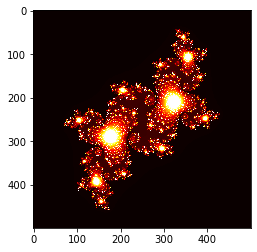

In [4]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm
fig, ax = plt.subplots()
ax.imshow(julia_img, interpolation='nearest', cmap=plt.get_cmap("hot"))
# plt.savefig(test.png)
plt.show()

In [5]:
def compute_patch(task):
    xmin, xmax, ymin, ymax, pxwidth, pyheight = task

    zabs_max = 10
    c = complex(-0.1, 0.65)
    nit_max = 1000

    xwidth = xmax - xmin
    yheight  =  ymax - ymin

    julia_patch = np.zeros((pxwidth, pyheight))
    for ix in range(pxwidth):
        for iy in range(pyheight):
            nit = 0
            # Map pixel position to a point in the complex plane
            z = complex(ix / pxwidth * xwidth + xmin,
                        iy / pyheight * yheight + ymin)
            # Do the iterations
            while abs(z) <= zabs_max and nit < nit_max:
                z = z**2 + c
                nit += 1
            ratio = nit / nit_max
            julia_patch[ix,iy] = ratio

    return julia_patch

In [14]:
def create_tasks(
    ymax, ymin, scaled_y, num_y_patches,
    xmax, xmin, scaled_x, num_x_patches,
    patch, size
):
    tasks = []
    pymax = ymax
    pymin = ymax - scaled_y
    for cidx in range(num_y_patches):
        pxmin = xmin
        pxmax = xmin + scaled_x
        ypsize = size - (num_y_patches-1) * patch if (cidx+1 == num_y_patches) else patch
    
        for ridx in range(num_x_patches):
            xpsize = size - (num_x_patches-1) * patch if (ridx+1 == num_x_patches) else patch
            tasks.append((pxmin, pxmax, pymin, pymax, xpsize, ypsize))
            pxmin = pxmax
            pxmax = xmax if (ridx + 2 == num_x_patches) else (pxmax + scaled_x)
        
        pymax = pymin
        pymin = ymin if (cidx + 2 == num_y_patches) else (pymin - scaled_y)
    return tasks
        

def compute_julia_in_parallel(size, xmin, xmax, ymin, ymax, patch, nprocs):
    pool = Pool(processes = nprocs)

    xwidth = xmax - xmin
    yheight = ymax - ymin
    # size of patches
    scaled_x = (xwidth/size) * patch
    scaled_y = (yheight/size) * patch
    # number of patches     
    num_x_patches = math.floor(xwidth / scaled_x) + 1
    num_y_patches = math.floor(yheight / scaled_y) + 1

    task_list = create_tasks(
        ymax, ymin, scaled_y, num_y_patches,
        xmax, xmin, scaled_x, num_x_patches,
        patch, size
    )
    completed_patches = pool.map(compute_patch, task_list, chunksize=1)
    pool.close()
    pool.join()

    row_patches = []
    for row in range(num_x_patches, num_x_patches*num_y_patches + 1, num_x_patches):
        row_patch = np.concatenate(completed_patches[row-num_x_patches:row], axis=0)
        row_patches.append(row_patch)

    image = np.concatenate(list(row_patches[::-1]), axis=1)

    return image

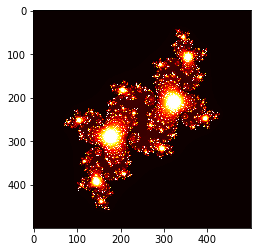

In [15]:
p = compute_julia_in_parallel(
    size=500,
    xmin=-1.5,
    xmax=1.5, 
    ymin=-1.5,
    ymax=1.5, 
    patch=20,
    nprocs=6)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
fig, ax = plt.subplots()
ax.imshow(p, interpolation='nearest', cmap=plt.get_cmap("hot"))
# plt.savefig(test.png)
plt.show()